In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os

In [2]:
# Path to the data directory
dat_dir = "/home/xcx/MYBenchmark-datas/1469/"

## Read Data

In [ ]:
from scipy import io
import pandas as pd
import numpy as np
import scipy
import scanpy as sc

path = os.path.join(dat_dir)
counts_rna = pd.read_csv(os.path.join(path, "counts_rna.csv"), header=0, index_col = 0).values.astype(float)
# count = scipy.sparse.csr_matrix(count)
barcode = pd.read_csv(os.path.join(path, "counts_rna.csv"), header=0, usecols=[0]).values.astype('str')
feature = pd.read_csv(os.path.join(path, "counts_rna.csv"), header=None, index_col = 0).values[0].astype('str')
barcode = barcode.reshape(1469, )

n_samples = len(barcode)
np.random.seed(0)
permuted_idx = np.random.permutation(n_samples)
train_idx = permuted_idx[:int(n_samples*0.2)]
test_idx = permuted_idx[int(n_samples*0.2):]

train_barcode = barcode[train_idx]
test_barcode = barcode[test_idx]
train_counts_rna = counts_rna[train_idx,:]
test_counts_rna = counts_rna[test_idx,:]

train_snare_mrna = SingleData("GeneExpr", "SNARE-seq", feature, train_counts_rna, train_barcode)
print(train_snare_mrna)
print(type(train_snare_mrna))

test_snare_mrna = SingleData("GeneExpr", "scRNA-seq", feature, test_counts_rna, test_barcode)
print(test_snare_mrna)
print(type(test_snare_mrna))

In [ ]:
from scipy import io
import pandas as pd
import numpy as np

path = os.path.join(dat_dir)
counts_atac = pd.read_csv(os.path.join(path, "counts_atac.csv"), header=0, index_col = 0).values.astype(float)
# count = scipy.sparse.csr_matrix(count)
count_atac = np.log1p(count)
barcode = pd.read_csv(os.path.join(path, "counts_atac.csv"), header=0, usecols=[0]).values.astype('str')
feature = pd.read_csv(os.path.join(path, "counts_atac.csv"), header=None, index_col = 0).values[0].astype('str')
barcode = barcode.reshape(1469, )

n_samples = len(barcode)
np.random.seed(0)
permuted_idx = np.random.permutation(n_samples)
train_idx = permuted_idx[:int(n_samples*0.2)]
test_idx = permuted_idx[int(n_samples*0.2):]

train_barcode = barcode[train_idx]
test_barcode = barcode[test_idx]
train_counts_atac = counts_atac[train_idx,:]
test_counts_atac = counts_atac[test_idx,:]

train_snare_atac = SingleData("ChromAccess", "SNARE-seq", feature, train_counts_atac, train_barcode)
print(train_snare_atac)
print(type(train_snare_atac))

test_snare_atac = SingleData("ChromAccess", "scATAC-seq", feature, test_counts_atac, test_barcode)
print(test_snare_atac)
print(type(test_snare_atac))

In [8]:
train_snare_mrna.count = scipy.sparse.csr_matrix(train_snare_mrna.count)
test_snare_mrna.count = scipy.sparse.csr_matrix(test_snare_mrna.count)
train_snare_atac.count = scipy.sparse.csr_matrix(train_snare_atac.count)
test_snare_atac.count = scipy.sparse.csr_matrix(test_snare_atac.count)

In [9]:
multi_dt = MultiomicDataset.from_singledata(
    test_snare_atac, test_snare_mrna, train_snare_atac, train_snare_mrna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- ChromAccess: 15857 features, 1469 cells, 2 batches.
- GeneExpr: 933 features, 1469 cells, 2 batches.
Joint cells:
- ChromAccess, GeneExpr: 293 cells.


model = Cobolt(dataset=multi_dt, lr=0.005, n_latent=10)
model.train(num_epochs=20)## Training

We now train the Cobolt model with the number of latent variables set to 10. We
use a small iteration in this vignette for illustration purpose. The default
number of iteration is set to 100.

In [10]:
import datetime
starttime = datetime.datetime.now()

model = Cobolt(dataset=multi_dt, lr=0.005, n_latent=10)
model.train(num_epochs=100)

#long running
endtime = datetime.datetime.now()
print((endtime-starttime).seconds)

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:55<00:00,  2.96s/it]

298


Calculate the corrected latent variables.

In [11]:
model.calc_all_latent()

The latent variables can be accessed through function `get_all_latent`.

In [12]:
latent = model.get_all_latent()

In [13]:
import pickle
model_out = os.path.join("/home/xcx/results/1469/9-cobolt","cobolt_1469_model.pickle")
pickle.dump(model, open(model_out, 'wb'))

The latent variables pre-correction can be accessed by setting the
`correction` parameter. The returned results contain all available posterior
means for each cell. For example, a SNARE-seq cell can have 3 posterior means,
corresponding to the posterior distribution given gene expression, given
chromatin accessibility, and given both modalities.

In [14]:
latent_raw = model.get_all_latent(correction=False)

## Clustering and Visualization

We can cluster cells on the latent variables using Leiden algorithm. Higher
resolution gives more clusters, and lower resolution gives fewer number of
clusters.

In [15]:
model.clustering(algo="leiden", resolution=0.2)

Running Leiden clustering algorithm with resolution 0.200.


Users are encouraged to try different resolution parameters. Calls to
`clustering` function will be stored in the object. Cluster results obtained
with a specific algorithm and resolution and can be accessed as the following.

In [16]:
clusters = model.get_clusters(algo="leiden", resolution=0.2)

Visualize the clustering results on UMAP.

Running UMAP with latent variable correction.


/data1/xcx/anaconda3/envs/cobolt/lib/python3.8/site-packages/cobolt/model/cobolt.py:452: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


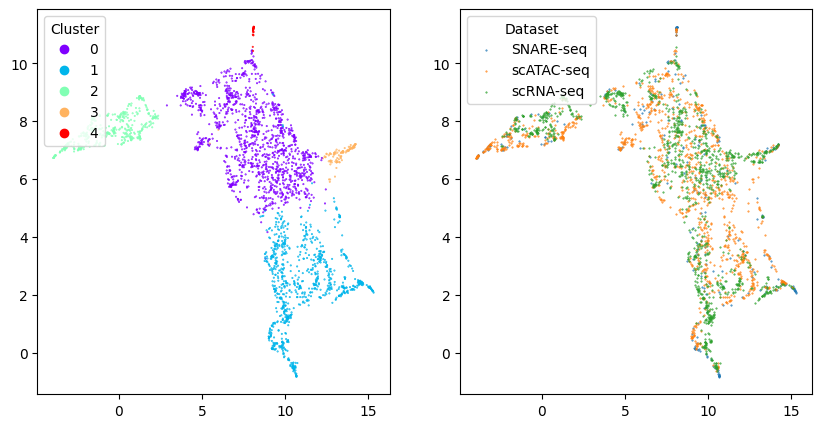

In [17]:
model.scatter_plot(reduc="UMAP", algo="leiden", resolution=0.2, s=0.2)

Access the UMAP reduced dimensions.

In [18]:
umap_reduc = model.reduction["UMAP2"]["embedding"]


In [19]:
latent_atac = latent[0][293:1469]
latent_rna = latent[0][1469:]

df = pd.DataFrame(data=latent_rna)
df.to_csv(os.path.join("/home/xcx/results/1469/9-cobolt/z_rna.csv"), index=False)
df = pd.DataFrame(data=latent_atac)
df.to_csv(os.path.join("/home/xcx/results/1469/9-cobolt/z_atac.csv"), index=False)

In [1]:
import pickle

with open('/home/xcx/results/1469/9-cobolt/cobolt_1469_model.pickle', 'rb') as f:
    model = pickle.load(f)


In [3]:
latent = model.get_all_latent()

In [13]:
import pandas as pd
import numpy as np
import os

pattern = "scRNA-seq~"
latent_rna = latent[1][1469:]

latent_rna_barcode = []
for barcode in latent_rna:
    new_text = np.array(barcode.split(pattern))[-1].strip()
    latent_rna_barcode.append(new_text)

# print(latent_rna_barcode)

import pandas as pd
import numpy as np
path = "/home/xcx/MYBenchmark-datas/1469/"
# cell_labels = pd.read_csv("/home/xcx/MYBenchmark-datas/1469/anno.txt", header = None).to_numpy()[:,0]
cell_barcodes = pd.read_csv(os.path.join(path, "counts_rna.csv"), header=0, usecols=[0]).values.astype('str').reshape(1469,)
print(cell_barcodes)

tests = {}
for i in range(cell_barcodes.shape[0]):
    tests[cell_barcodes[i]] = i
    
index = []
for i in range(len(latent_rna_barcode)):
    index.append(tests[latent_rna_barcode[i]])
    
df = pd.DataFrame(data=index)
df.to_csv(os.path.join("/home/xcx/MYBenchmark-codes/9-cobolt/mydata/1469/selected_index.csv"), index=False)

['GGCAATGGCCCT' 'CTACACCACACC' 'ACCTGGCCTGCC' ... 'CATGTTTGCAAA'
 'TTAGACCCGCTA' 'TCGCGACTCGCG']
